In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import numpy as np
from itertools import tee
from gui.user_code import pairwise_randomised_significance, get_data_for_signif_test, pairwise_significance_exp_ids
from gui.output_utils import get_cv_fold_count, get_cv_scores_many_experiment
from gui.constants import CLASSIFIER
from discoutils.collections_utils import walk_overlapping_pairs

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# Does the classification evaluation framework work?
What is the effect of adding uniform random noise to vectors? Can our experiments tell between a set of vectors and a corrupted version of the same vectors? To find out, add uniform random noise from $-n$ to $n$ (x axis) to all non-zero entries in a set of `word2vec` embeddings.
     

In [2]:
def plot(d):
    experiments = Experiment.objects.filter(**d).order_by('expansions__noise')
    e = [x.id for x in experiments if x.expansions.entries_of is None]
    print('experiments are', e)

    for eid in e:
        print('id %d noise %2.2f, acc %2.2f, macrof1 %2.2f'%(eid,
                                              Experiment.objects.get(id=eid).expansions.noise,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).accuracy_mean,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).macrof1_mean))

    df = dataframe_from_exp_ids(e, {'noise':'expansions__noise'})
    df['noise'] = ['%1.1f'%float(x) for x in df.noise]
#     ax = sns.factorplot(x='noise', y='Accuracy', data=df, kind='point', aspect=1.5);
    ax = sns.tsplot(df, time='noise', value='Accuracy', unit='folds', marker='o')
#     ax.set_xlabels('')

    # random baseline for comparison
    plt.axhline(random_vect_baseline(corpus=d['labelled']), c='k')
    
    significance_df = pairwise_significance_exp_ids(walk_overlapping_pairs(e), ['expansions__noise'])
    return significance_df

experiments are [34, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
id 34 noise 0.00, acc 0.53, macrof1 0.49
id 87 noise 0.20, acc 0.53, macrof1 0.49
id 88 noise 0.40, acc 0.50, macrof1 0.45
id 89 noise 0.60, acc 0.44, macrof1 0.41
id 90 noise 0.80, acc 0.39, macrof1 0.34
id 91 noise 1.00, acc 0.34, macrof1 0.31
id 92 noise 1.20, acc 0.31, macrof1 0.28
id 93 noise 1.40, acc 0.28, macrof1 0.25
id 94 noise 1.60, acc 0.27, macrof1 0.24
id 95 noise 1.80, acc 0.26, macrof1 0.22
id 96 noise 2.00, acc 0.25, macrof1 0.21
folds has 5500 values
Accuracy has 5500 values
noise has 5500 values
Running significance for (34, 87)
Running significance for (87, 88)
Running significance for (88, 89)
Running significance for (89, 90)
Running significance for (90, 91)
Running significance for (91, 92)
Running significance for (92, 93)
Running significance for (93, 94)
Running significance for (94, 95)
Running significance for (95, 96)


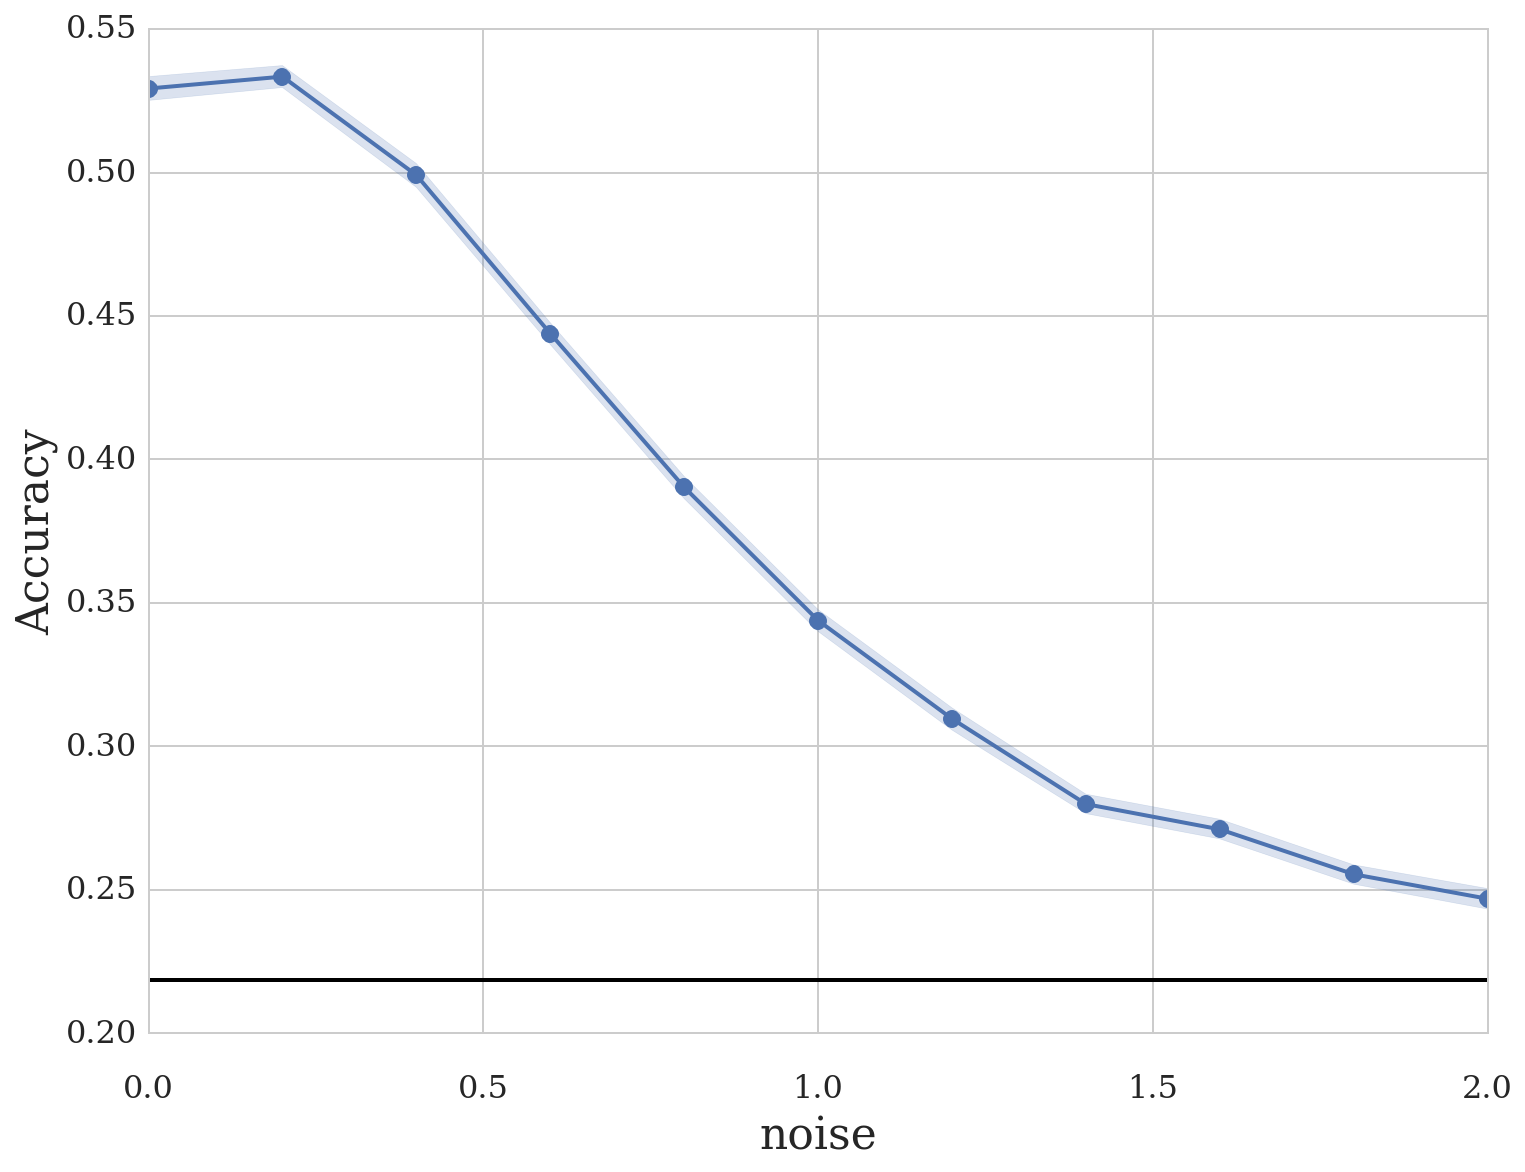

In [3]:
d = {'expansions__vectors__unlabelled_percentage': 100,
     'labelled': 'amazon_grouped-tagged',
     'expansions__vectors__dimensionality': 100,
     'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
     'expansions__vectors__composer': 'Add',
     'expansions__vectors__rep': 0, 
     'expansions__allow_overlap': False,
     'expansions__k': 3,
     'expansions__vectors__unlabelled': 'wiki',
     'expansions__vectors__algorithm': 'word2vec',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN',
     'labelled': 'amazon_grouped-tagged'}
df = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [4]:
df

,name1,acc1,name2,acc2,mean_diff,pval,significant
0,0.0,0.529542,0.2,0.533649,0.004108,0.466,False
1,0.2,0.533649,0.4,0.499328,0.034322,0.000,True
2,0.4,0.499328,0.6,0.444075,0.055252,0.000,True
3,0.6,0.444075,0.8,0.390308,0.053768,0.000,True
4,0.8,0.390308,1.0,0.343826,0.046482,0.000,True
5,1.0,0.343826,1.2,0.309475,0.034351,0.000,True
6,1.2,0.309475,1.4,0.279913,0.029562,0.000,True
7,1.4,0.279913,1.6,0.271294,0.008620,0.078,False
8,1.6,0.271294,1.8,0.255906,0.015388,0.002,True
9,1.8,0.255906,2.0,0.247031,0.008875,0.086,False


# Question
In thesis `v0.13` this graph didn't look right (Figure 8). 

experiments are [135, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]
id 135 noise 0.00, acc 0.68, macrof1 0.67
id 169 noise 0.20, acc 0.56, macrof1 0.48
id 170 noise 0.40, acc 0.54, macrof1 0.46
id 171 noise 0.60, acc 0.62, macrof1 0.58
id 172 noise 0.80, acc 0.54, macrof1 0.46
id 173 noise 1.00, acc 0.49, macrof1 0.37
id 174 noise 1.20, acc 0.51, macrof1 0.41
id 175 noise 1.40, acc 0.50, macrof1 0.39
id 176 noise 1.60, acc 0.49, macrof1 0.37
id 177 noise 1.80, acc 0.51, macrof1 0.41
id 178 noise 2.00, acc 0.51, macrof1 0.40
folds has 5500 values
Accuracy has 5500 values
noise has 5500 values
Running significance for (135, 169)
Running significance for (169, 170)
Running significance for (170, 171)
Running significance for (171, 172)
Running significance for (172, 173)
Running significance for (173, 174)
Running significance for (174, 175)
Running significance for (175, 176)
Running significance for (176, 177)
Running significance for (177, 178)


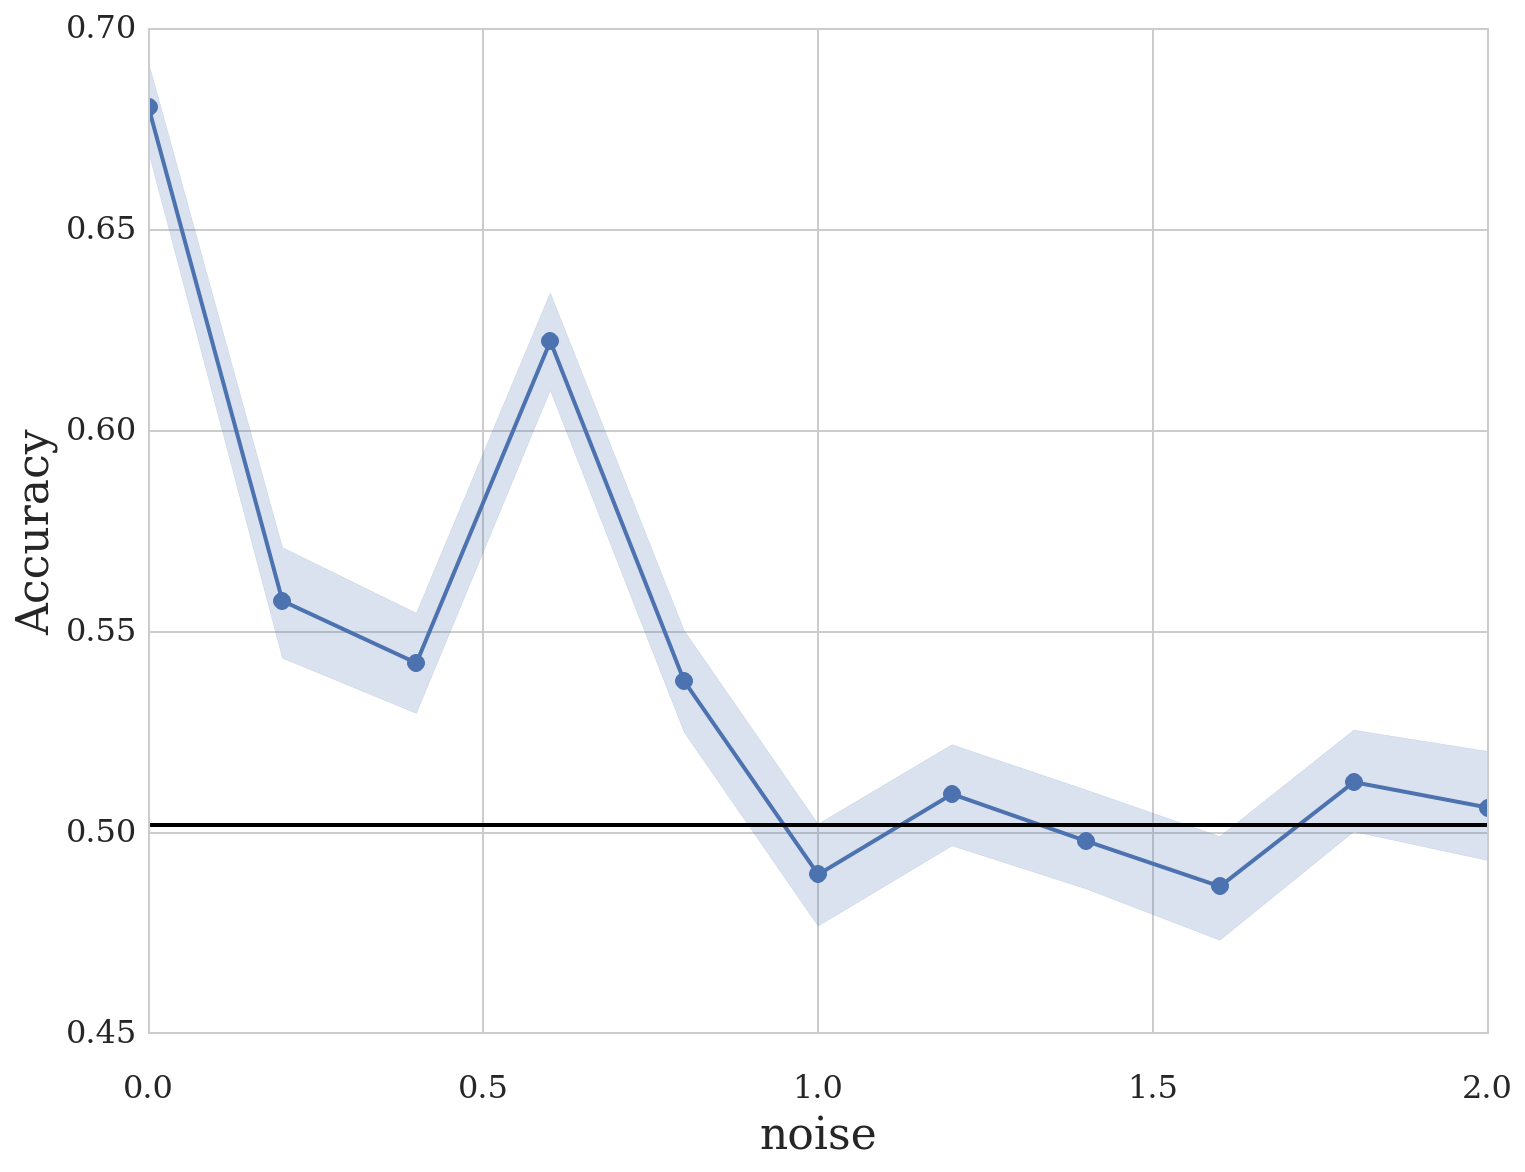

In [5]:
d['labelled'] = 'reuters21578/r8-tagged-grouped'
df2 = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-r2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)